# Given a potential suite of simulations, figure out emulator space covered

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import copy
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import camb_cosmo
import fit_linP
import sim_params_cosmo
import sim_params_space
import read_genic
import write_config
import latin_hypercube
import corner
import p1d_arxiv

### Plot initial Latin hypercube

In [2]:
# get list of simulation parameters
add_slope=True
add_running=True
add_mu_He=False
add_mu_H=False
param_space=sim_params_space.SimulationParameterSpace(add_slope=add_slope,add_running=add_running,
                                                      add_mu_He=add_mu_He,add_mu_H=add_mu_H)
params=param_space.params
for key,param in params.items():
    print(key,param)

Om_star {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}
Delta2_star {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}
n_star {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}
alpha_star {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}


In [3]:
# get pivot point
z_star=params['Om_star']['z_star']
kp_Mpc=params['Delta2_star']['kp_Mpc']
print('z_star =',z_star)
print('kp_Mpc =',kp_Mpc)
Npar=len(params)
param_limits=np.empty([Npar,2])
for key,param in params.items():
    ip=param['ip']
    param_limits[ip][0]=param['min_val']
    param_limits[ip][1]=param['max_val']

z_star = 3.0
kp_Mpc = 0.7


In [4]:
# generate Latin hypercube 
nsamples=10
seed=123
cube=latin_hypercube.get_hypercube_samples(param_limits, nsamples, prior_points = None, seed=seed)

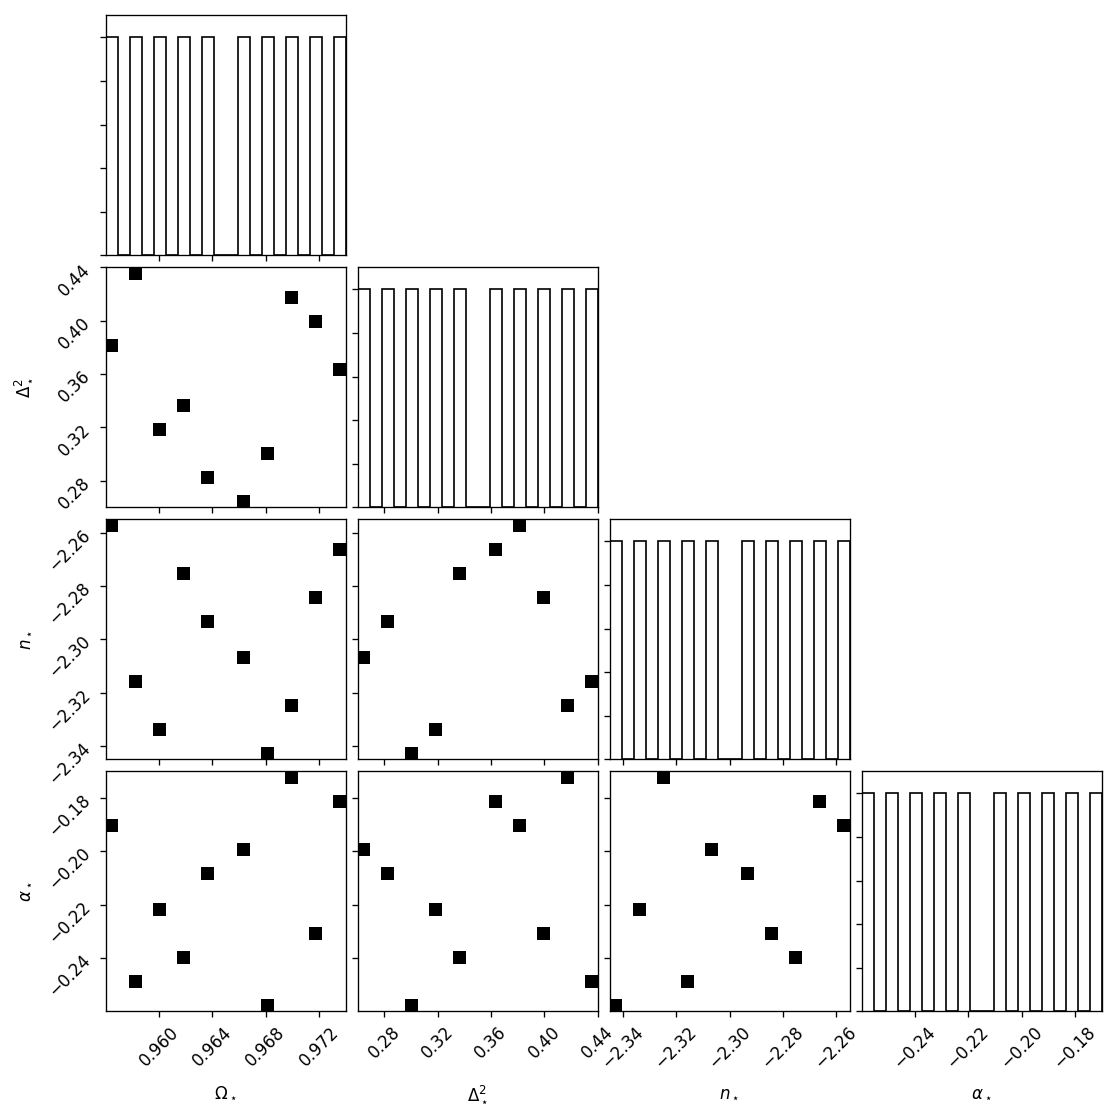

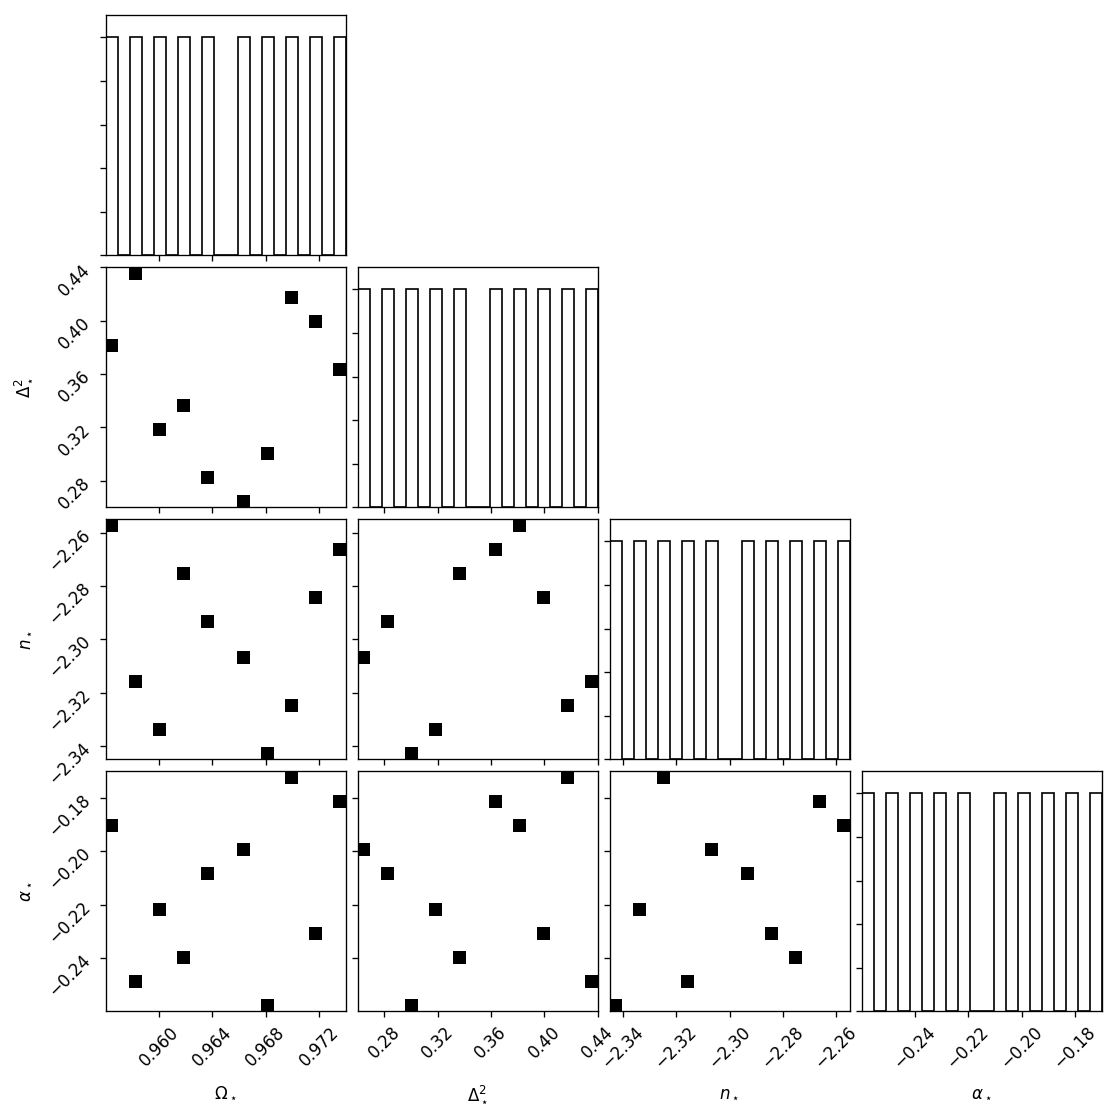

In [5]:
labels=['']*Npar
for key,param in params.items():
    ip=param['ip']
    labels[ip]=param['latex']
corner.corner(cube,labels=labels)

###  Plot cosmological parameters in initial setup

In [6]:
# get fiducial cosmology
cosmo_fid = camb_cosmo.get_cosmology()
camb_cosmo.print_info(cosmo_fid)
# setup fiducial linear power model
linP_model_fid=fit_linP.LinearPowerModel(cosmo_fid,z_star=z_star,k_units='Mpc',kp=kp_Mpc)
print('fiducial linear power parameters',linP_model_fid.get_params())

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, T_CMB = 2.7255E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00
fiducial linear power parameters {'f_star': 0.98136951686066309, 'g_star': 0.9677508579459803, 'Delta2_star': 0.36391885574433314, 'n_star': -2.3025651886411502, 'alpha_star': -0.21497062246191764}


 - For each point in cube, write configuration files to run simulation

In [8]:
zs=[9.0,5.0,4.0,3.0,2.0]
sims_dir='test_cube/'
os.makedirs(sims_dir,exist_ok=True)
write_config.write_cube_json_file(sims_dir,params,cube)
info_cosmologies=[]
for sample in range(nsamples):
    sim_params=cube[sample]
    print(sample,sim_params)
    cosmo_sim=sim_params_cosmo.cosmo_from_sim_params(params,sim_params,linP_model_fid,verbose=False)
    sim_dir=sims_dir+'/sim_pair_'+str(sample)+'/'
    os.makedirs(sim_dir,exist_ok=True)
    # construct linear power model and store in JSON format
    linP_model_sim=fit_linP.LinearPowerModel(cosmo_sim,z_star=z_star,k_units='Mpc',kp=kp_Mpc)
    write_config.write_sim_json_file(sim_dir,params,sim_params,linP_model_sim,zs=zs)
    # store information for plots
    info_cosmo={'cosmo':cosmo_sim,'sim_params':sim_params,'linP_params':linP_model_sim.get_params()}
    info_cosmologies.append(info_cosmo)

0 [ 0.96   0.32  -2.335 -0.22 ]
1 [ 0.974  0.36  -2.265 -0.18 ]
2 [ 0.964  0.28  -2.295 -0.21 ]
3 [ 0.962  0.34  -2.275 -0.24 ]
4 [ 0.972  0.4   -2.285 -0.23 ]
5 [ 0.966  0.26  -2.305 -0.2  ]
6 [ 0.97   0.42  -2.325 -0.17 ]
7 [ 0.958  0.44  -2.315 -0.25 ]
8 [ 0.956  0.38  -2.255 -0.19 ]
9 [ 0.968  0.3   -2.345 -0.26 ]


In [9]:
print('linP_params',info_cosmologies[0]['linP_params'])
print('sim_params',info_cosmologies[0]['sim_params'])

linP_params {'f_star': 0.97730084781365167, 'g_star': 0.9604223458127262, 'Delta2_star': 0.31999999999999901, 'n_star': -2.335, 'alpha_star': -0.21999999999999614}
sim_params [ 0.96   0.32  -2.335 -0.22 ]


['$H_0$', '$\\Omega_m$', '$A_s$', '$n_s$', '$\\alpha_s$']


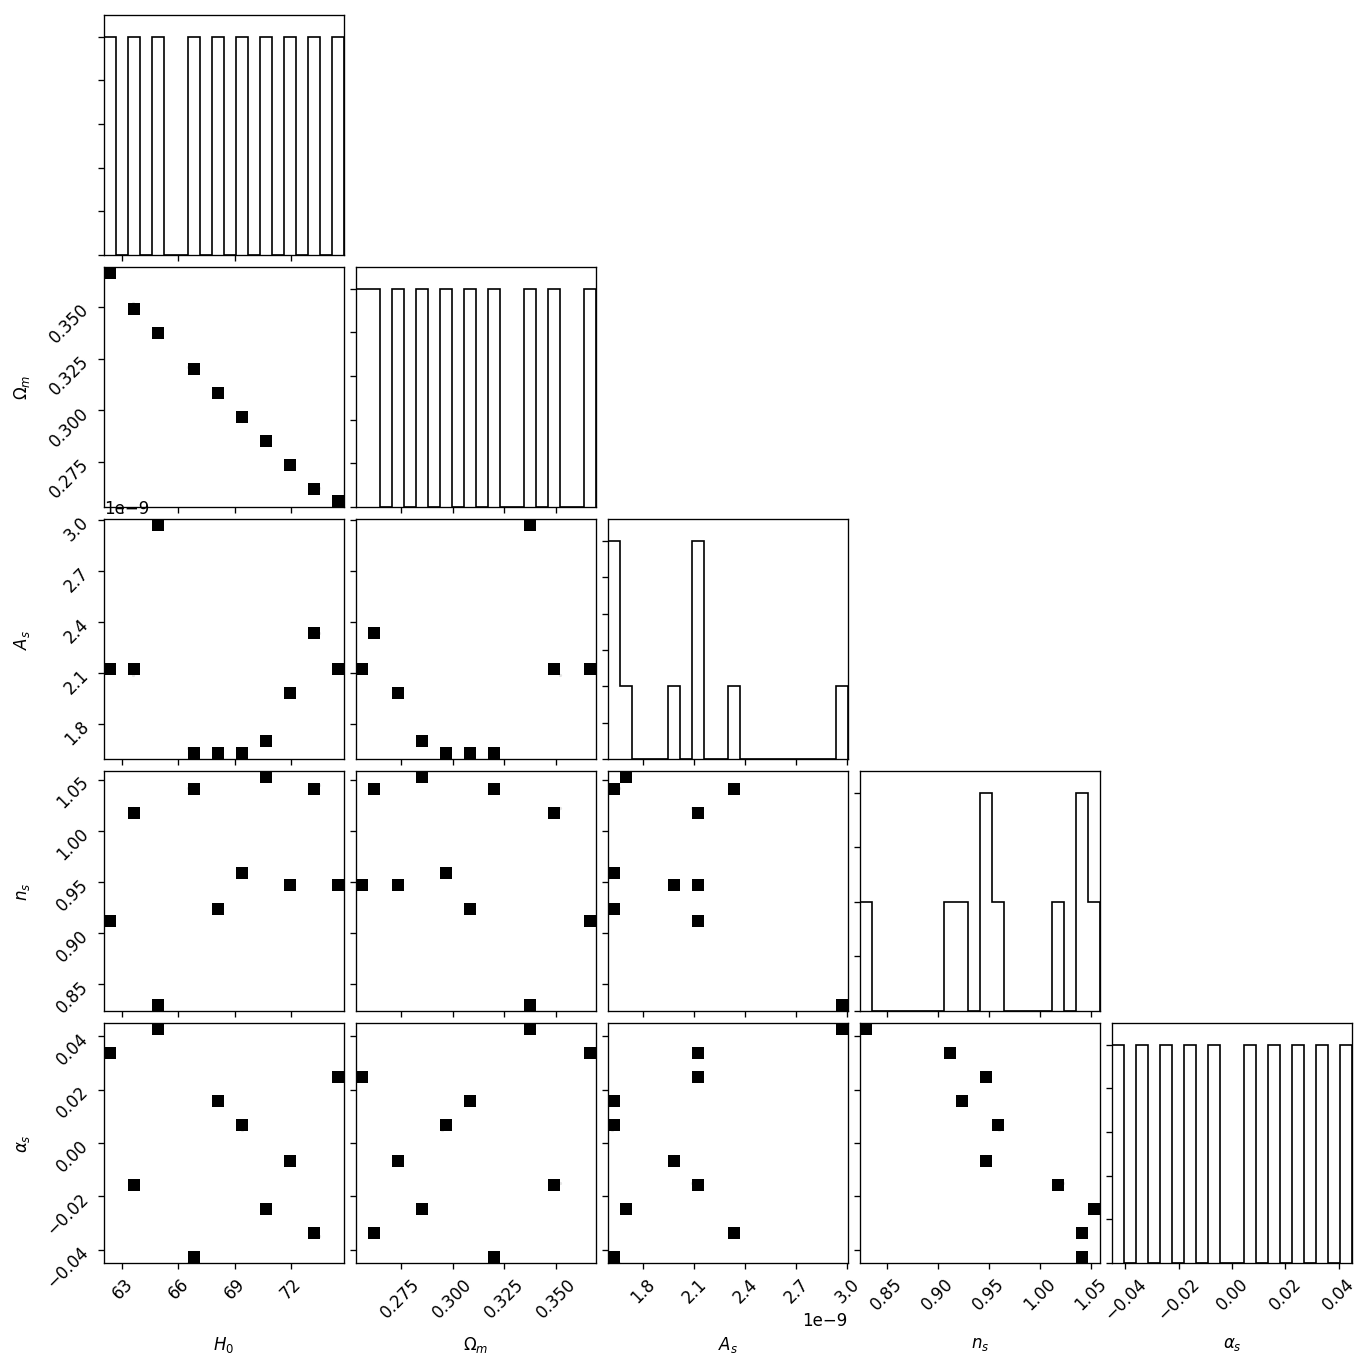

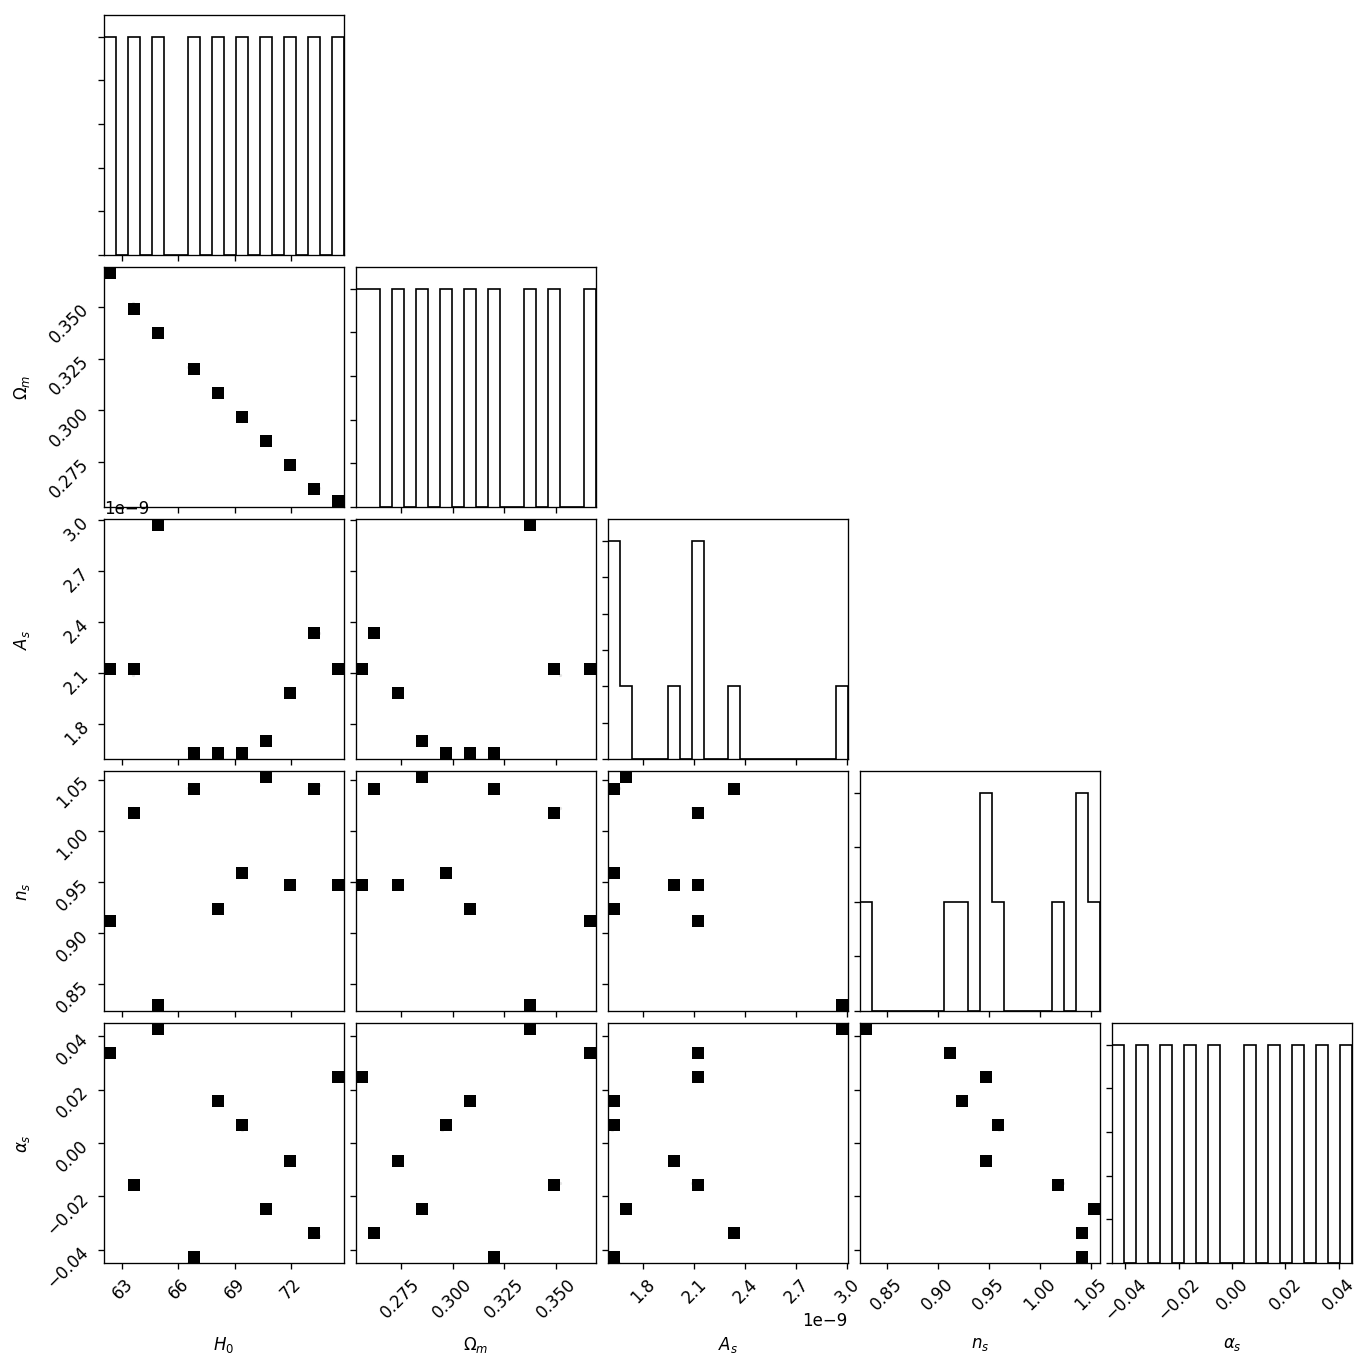

In [10]:
# plot corner plot for derived parameters
derived_labels=[r'$H_0$',r'$\Omega_m$',r'$A_s$']
if add_slope:
    derived_labels.append(r'$n_s$')
if add_running:
    derived_labels.append(r'$\alpha_s$')
Npar=len(derived_labels)
Ncos=len(info_cosmologies)
print(derived_labels)
derived_params=np.ndarray([Ncos,Npar])
for icosmo in range(Ncos):
    cosmo = info_cosmologies[icosmo]['cosmo']
    H0=cosmo.H0
    h=H0/100.0
    omh2=cosmo.omch2+cosmo.ombh2
    derived_params[icosmo][0]=H0
    derived_params[icosmo][1]=(omh2/h**2)
    derived_params[icosmo][2]=cosmo.InitPower.As
    if add_slope:
        derived_params[icosmo][3]=cosmo.InitPower.ns
    if add_running:
        derived_params[icosmo][4]=cosmo.InitPower.nrun
corner.corner(derived_params,labels=derived_labels)

In [11]:
arxiv=p1d_arxiv.ArxivP1D(basedir=sims_dir,skewers_label=None,verbose=True)
Nmodels=len(arxiv.data)
print('# models =',Nmodels)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}}, 'nsamples': 6, 'samples': {'0': [0.97, 0.4, -2.3083333333333336, -0.22333333333333336, 1.375], '1': [0.96, 0.3333333333333333, -2.275, -0.2066666666666667, 0.875], '2': [0.9633333333333333, 0.3, -2.2583333333333333, -0.24000000000000002, 1.625], '3': [0.9666666666666667, 0.36666666666666664, -2.325, -0.19, 1.125], '4': [0.9733333333333333, 0.26666666666666666, -2.2916666666666665, -0.17333333333333334, 1.875], '5': [0.95

In [12]:
labels=[r'$\Delta_p^2$',r'$n_p$',r'$\alpha_p$',r'$f_p$']
Npar=len(labels)
database=np.empty([Nmodels,Npar])
database[:,0]=arxiv.Delta2_p
database[:,1]=arxiv.n_p
database[:,2]=arxiv.alpha_p
database[:,3]=arxiv.f_p

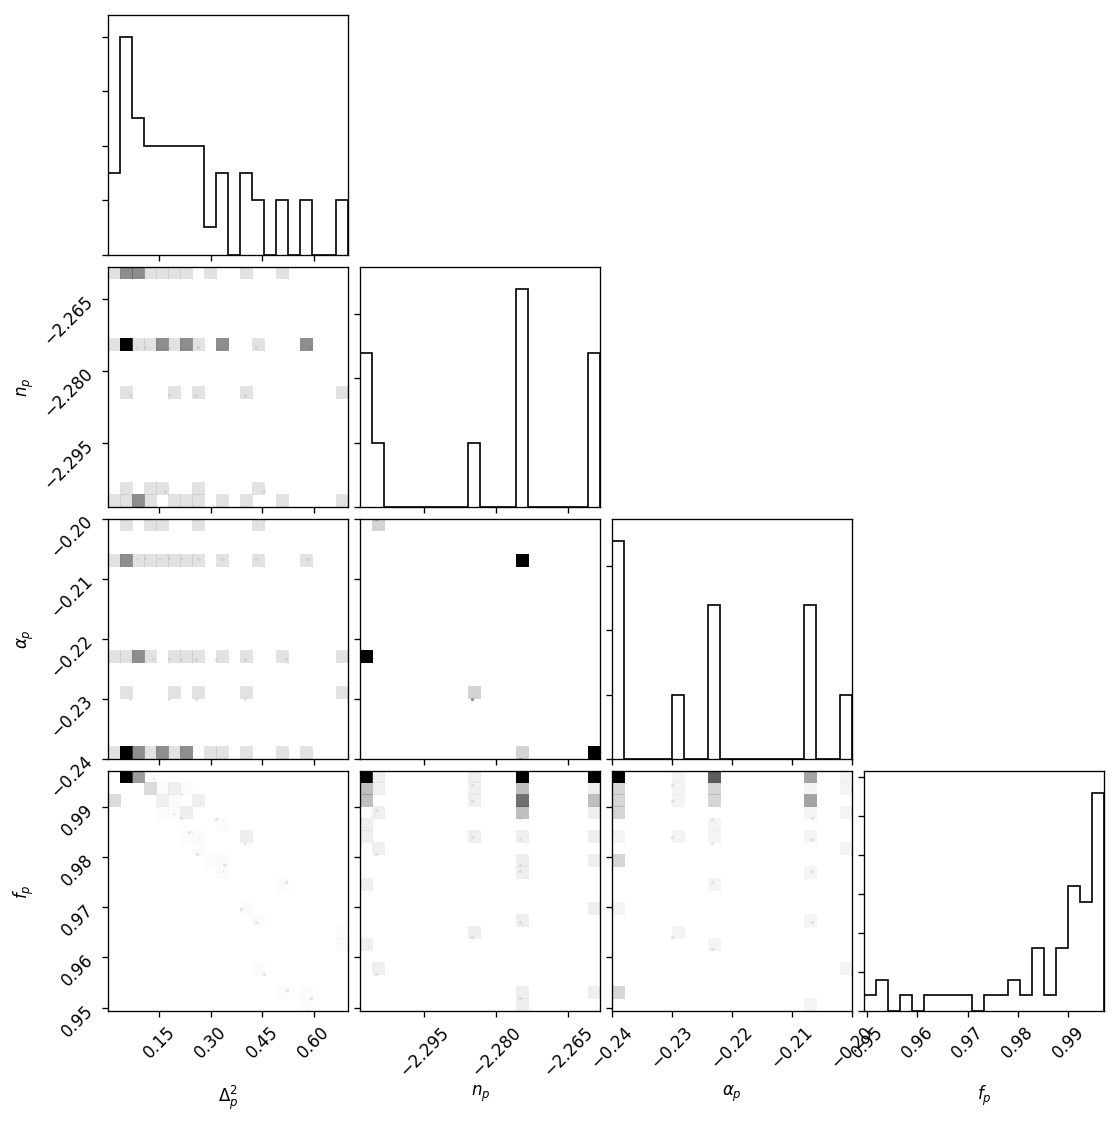

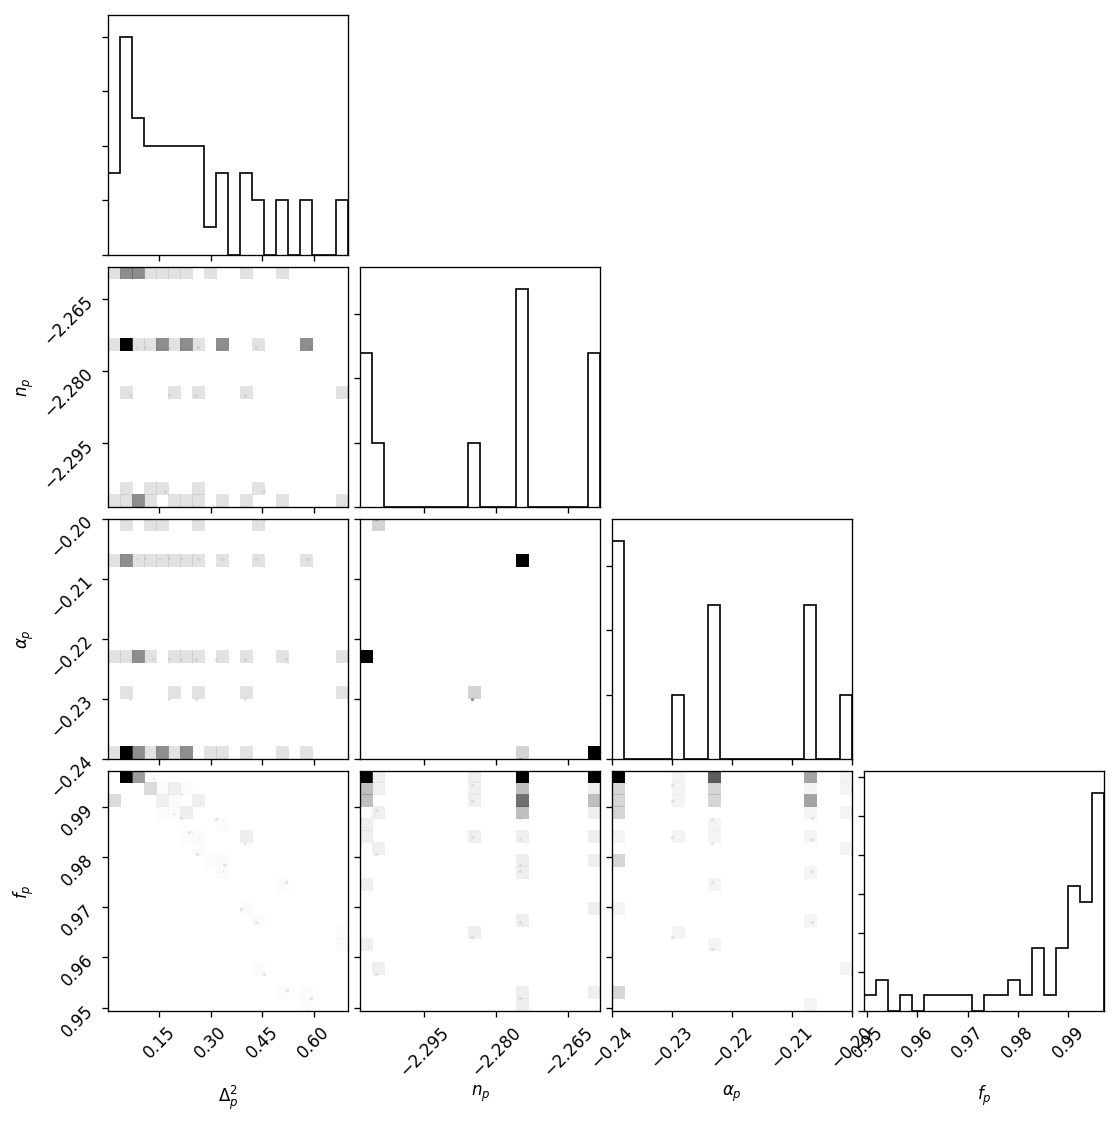

In [13]:
corner.corner(database, labels=labels,plot_contours=False)

In [14]:
def plot_parameter_pair(arxiv,param_1,param_2,plot_z=True):
    # figure out values of param_1,param_2 in arxiv
    val_1=np.array([arxiv.data[i][param_1] for i in range(len(arxiv.data))])
    print(param_1,'first values in arxiv',val_1[:5])
    val_2=np.array([arxiv.data[i][param_2] for i in range(len(arxiv.data))])
    print(param_2,'first values in arxiv',val_2[:5])
    if plot_z:
        z=np.array([arxiv.data[i]['z'] for i in range(len(arxiv.data))])
        zmin=min(z)
        zmax=max(z)
        plt.scatter(val_1,val_2,c=z,s=5,vmin=zmin, vmax=zmax)
        cbar=plt.colorbar()
        cbar.set_label("Redshift", labelpad=+1)
    else:
        plt.scatter(val_1,val_2,s=5)
    plt.xlabel(param_1)
    plt.ylabel(param_2)

Delta2_p first values in arxiv [ 0.00263582  0.06482388  0.0799763   0.10113729  0.13195354]
f_p first values in arxiv [ 0.99037391  0.99710909  0.99688099  0.99644362  0.99560679]


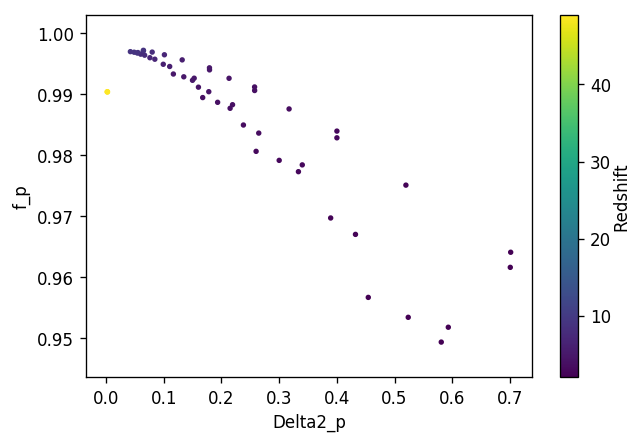

In [15]:
plot_parameter_pair(arxiv,'Delta2_p','f_p')

n_p first values in arxiv [-2.30832936 -2.30833416 -2.30833395 -2.30833409 -2.30833381]
alpha_p first values in arxiv [-0.22333712 -0.22333578 -0.22333559 -0.22333498 -0.2233348 ]


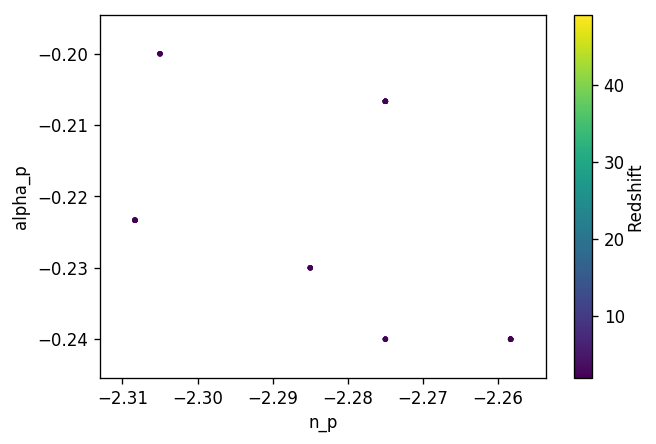

In [16]:
plot_parameter_pair(arxiv,'n_p','alpha_p')